In [183]:
import torch
from torch import nn
from torch import optim

import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

In [184]:
class CustomDataset(Dataset):

    def __init__(self, dataframe: pd.DataFrame, feature_names: list, target_name: str):
        scaler = StandardScaler()
        X = scaler.fit_transform(dataframe[feature_names])
        X = torch.tensor(X, dtype=torch.float32)
        
        self.X = X.reshape(X.shape[0], 1, X.shape[1])
        self.y = torch.tensor(dataframe[target_name].values, dtype=torch.float32)
        
    def __len__(self) -> int:
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [185]:
class FullyConnectedNet(nn.Module):

    def __init__(self, in_size: int, hidden_size: list, out_size: int):
        super(FullyConnectedNet, self).__init__()

        self.Network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_size, hidden_size[0]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size[1], hidden_size[2]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size[2], hidden_size[3]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size[3], out_size),
        )
    
    def forward(self, x):
        return self.Network(x)


In [186]:
df = pd.read_csv("data\df_01.csv", index_col=[0])
df = df.reset_index().drop(columns=['index'])

In [187]:
lithology_keys = {30000: 0,
                  65030: 1,
                  65000: 2,
                  80000: 3,
                  74000: 4,
                  70000: 5,
                  70032: 6,
                  88000: 7,
                  86000: 8,
                  99000: 9,
                  90000: 10,
                  93000: 11}

In [188]:
df['FORCE_2020_LITHOFACIES_LITHOLOGY'] = df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)

In [189]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_ecoded = encoder.fit_transform(df[['FORCE_2020_LITHOFACIES_LITHOLOGY']])
one_hot_df = pd.DataFrame(one_hot_ecoded, columns=encoder.get_feature_names_out())
df = pd.concat([df, one_hot_df], axis=1)

In [191]:
feature_names = ['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RMED', 'RDEP', 'RHOB',
                 'GR', 'NPHI', 'PEF', 'DTC', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'ROPA']

target_name = ['FORCE_2020_LITHOFACIES_LITHOLOGY_0', 'FORCE_2020_LITHOFACIES_LITHOLOGY_1', 
               'FORCE_2020_LITHOFACIES_LITHOLOGY_2', 'FORCE_2020_LITHOFACIES_LITHOLOGY_3',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_4', 'FORCE_2020_LITHOFACIES_LITHOLOGY_5',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_6', 'FORCE_2020_LITHOFACIES_LITHOLOGY_7', 
               'FORCE_2020_LITHOFACIES_LITHOLOGY_8', 'FORCE_2020_LITHOFACIES_LITHOLOGY_9',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_10']

In [192]:
df_test = df.sample(frac=0.2)
df_train = df.loc[~df.index.isin(df_test.index)]

In [193]:

train_dataset = CustomDataset(dataframe=df_train, feature_names=feature_names, target_name=target_name)
train_data = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, )

test_dataset = CustomDataset(dataframe=df_test, feature_names=feature_names, target_name=target_name)
test_data = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True, )

In [194]:
train_dataset.y

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

In [195]:
train_dataset.X.shape

torch.Size([97139, 1, 18])

In [196]:
train_dataset.y.shape

torch.Size([97139, 11])

In [197]:
test_dataset.X.shape

torch.Size([24285, 1, 18])

In [198]:
test_dataset.y.shape

torch.Size([24285, 11])

In [199]:
len(target_name)

11

In [200]:
model = FullyConnectedNet(in_size=len(feature_names), hidden_size=[288, 144, 72, 36], out_size=len(target_name))
print(model)

FullyConnectedNet(
  (Network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=18, out_features=288, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=288, out_features=144, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=144, out_features=72, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=72, out_features=36, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.2, inplace=False)
    (13): Linear(in_features=36, out_features=11, bias=True)
  )
)


In [201]:
optimizer = optim.Adam(params=model.parameters(), lr=0.01, weight_decay=0.001)
loss_function = nn.CrossEntropyLoss()

In [202]:
epochs = 10
model.train()

FullyConnectedNet(
  (Network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=18, out_features=288, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=288, out_features=144, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=144, out_features=72, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=72, out_features=36, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.2, inplace=False)
    (13): Linear(in_features=36, out_features=11, bias=True)
  )
)

In [203]:
for e in range(epochs):
    loss_mean = 0
    lm_count = 0

    train_tqdm = tqdm(train_data, leave=True)
    for x_train, y_train in train_tqdm:
        predict = model(x_train)
        loss = loss_function(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        train_tqdm.set_description(f'Epoch [{e+1}/{epochs}], loss_mean={loss_mean:.3f} ')

Epoch [10/10], loss_mean=0.543 : 100%|██████████| 1518/1518 [00:28<00:00, 54.16it/s]


In [204]:
model.eval()

FullyConnectedNet(
  (Network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=18, out_features=288, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=288, out_features=144, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=144, out_features=72, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=72, out_features=36, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.2, inplace=False)
    (13): Linear(in_features=36, out_features=11, bias=True)
  )
)

In [205]:
predictions = []
tests = []
test_tqdm = tqdm(test_data, leave=True)
for x_test, y_test in test_tqdm:
    predict = model(x_test)
    predict = torch.argmax(predict, dim=1)
    y_test = torch.argmax(y_test, dim=1)
    predictions.extend(predict.cpu().detach().numpy().tolist())
    tests.extend(y_test.cpu().detach().numpy().tolist())

  0%|          | 0/380 [00:00<?, ?it/s]

100%|██████████| 380/380 [00:02<00:00, 189.73it/s]


In [206]:
from sklearn.metrics import confusion_matrix, classification_report

In [207]:
print(classification_report(tests, predictions))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      2942
           1       0.75      0.53      0.62      2152
           2       0.91      0.97      0.94     13893
           3       0.83      0.47      0.60      1056
           4       0.25      0.02      0.03        54
           5       0.75      0.71      0.73      1685
           6       0.83      0.96      0.89       579
           7       0.96      1.00      0.98      1305
           8       0.74      0.73      0.74       127
           9       0.80      0.66      0.73       454
          10       0.00      0.00      0.00        38

    accuracy                           0.87     24285
   macro avg       0.69      0.63      0.64     24285
weighted avg       0.86      0.87      0.86     24285



c:\Users\tatya\Documents\well_log\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tatya\Documents\well_log\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tatya\Documents\well_log\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

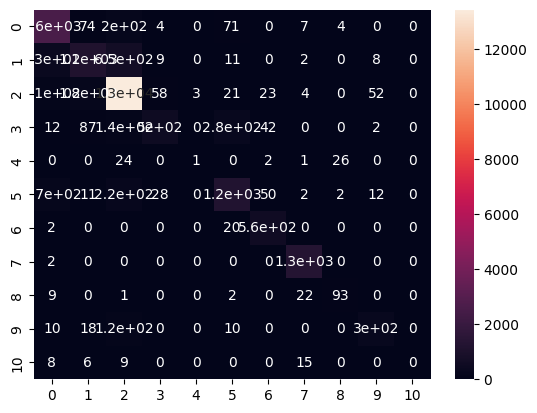

In [208]:
cm = confusion_matrix(tests, predictions)
sns.heatmap(cm, annot=True)

In [209]:
torch.save(model.state_dict(), 'models/fully_connected.tar')

In [210]:
model_2 = FullyConnectedNet(in_size=len(feature_names), hidden_size=[288, 144, 72, 36], out_size=len(target_name))
state_dict = torch.load('models/fully_connected.tar', weights_only=True)
model_2.load_state_dict(state_dict)

<All keys matched successfully>